In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

ts = TimeSeries(key='8VHYYYZR0BTCNJ2F', output_format='pandas')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime
#from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [3]:
#df = pd.read_csv('../dataset/GOOG-year.csv')
#df.head()
df,_ = ts.get_daily(symbol='GOOG', outputsize='full')
df.iloc[0:253, 3:4]

,4. close
date,
2020-03-05,1319.04
2020-03-04,1386.52
2020-03-03,1341.39
2020-03-02,1389.11
2020-02-28,1339.33
2020-02-27,1318.09
2020-02-26,1393.18
2020-02-25,1388.45
2020-02-24,1421.59


In [5]:
minmax = MinMaxScaler().fit(df.iloc[0:253, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[0:253, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df = df.iloc[0:253, 3:4]

In [119]:
data = pd.DataFrame.to_numpy(df)
np.save('goog.npy', data)

In [6]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((253, 1), (223, 1), (30, 1))

In [159]:
# Root Mean Square Percentage Error (RMSPE)
def calculate_accuracy(real, predict):
    #print(real)
    real = np.array(real)
    predict = np.array(predict)
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [67]:
num_layers = 1
size_layer = 128
timestamp = 5 # Each week
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [30]:
class LSTM:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [36]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    results.append(deep_future[-test_size:])

W0306 17:31:12.535528 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb114136be0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1


W0306 17:34:20.365996 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb1140ee9e8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2


W0306 17:37:32.678522 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb0f406ec88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


W0306 17:40:39.860021 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb0d4181ba8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


W0306 17:43:48.578633 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb0b431aac8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


W0306 17:46:53.025149 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb09466a588>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 6


W0306 17:49:59.980357 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb07c690438>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 7


W0306 17:53:06.769523 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb06c6139b0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 8


W0306 17:56:17.037532 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb034722908>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 9


W0306 17:59:31.299880 140407755728704 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb034040c88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 10


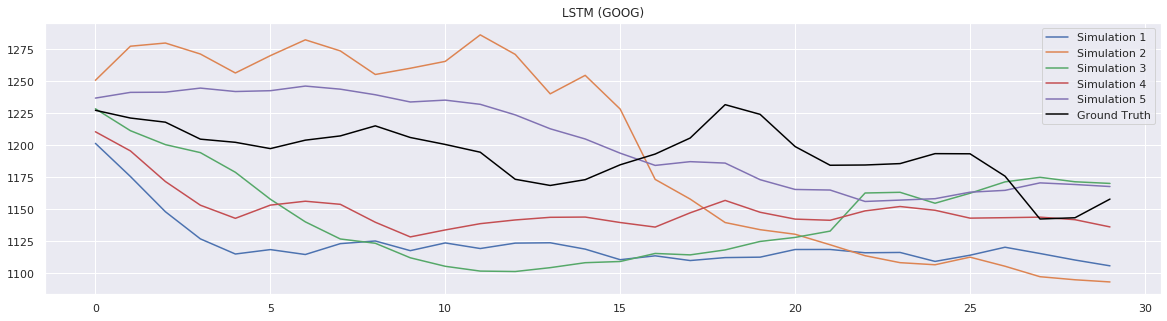

In [201]:
acc1 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results]
top_5_idx = np.argsort(acc1)[-5:]
results = [results[i] for i in top_5_idx]
acc1 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM (GOOG)')
plt.show()

In [87]:
class LSTM_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [90]:
results2 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results2.append(deep_future[-test_size:])

W0305 21:09:45.217066 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f0a486b06d8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0305 21:09:45.218310 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f09c4090fd0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=83.6, cost=0.128]


train loop:   0%|          | 1/300 [00:00<03:57,  1.26it/s, acc=83.6, cost=0.128]


train loop:   0%|          | 1/300 [00:01<03:57,  1.26it/s, acc=88.9, cost=0.0546]


train loop:   1%|          | 2/300 [00:01<03:54,  1.27it/s, acc=88.9, cost=0.0546]


train loop:   1%|          | 2/300 [00:02<03:54,  1.27it/s, acc=89.5, cost=0.0478]


train loop:   1%|          | 3/300 [00:02<03:54,  1.27it/s, acc=89.5, cost=0.0478]


train loop:   1%|          | 3/300 [00:03<03:54,  1.27it/s, acc=90, cost=0.037]   


train loop:   1%|▏         | 4/300 [00:03<04:00,  1.23it/s, acc=90, cost=0.037]


train loop:   1%|▏         | 4/300 [00:03<04:00,  1.23it/s, acc=89.9, cost=0.0387]


train loop:   2%|▏         | 5/300 [00:03<03:54,  1.26it/s, acc=89.9, cost=0.0387]


train loop:   2%|▏         | 5/300 [00:04<03:54,  1.26it/s, acc=89.7, cost=0.0354]


train loop:   2%|▏   

train loop:  28%|██▊       | 85/300 [01:13<03:09,  1.14it/s, acc=95.4, cost=0.00692]


train loop:  29%|██▊       | 86/300 [01:13<03:07,  1.14it/s, acc=95.4, cost=0.00692]


train loop:  29%|██▊       | 86/300 [01:14<03:07,  1.14it/s, acc=94.9, cost=0.00857]


train loop:  29%|██▉       | 87/300 [01:14<03:07,  1.14it/s, acc=94.9, cost=0.00857]


train loop:  29%|██▉       | 87/300 [01:15<03:07,  1.14it/s, acc=94.4, cost=0.0114] 


train loop:  29%|██▉       | 88/300 [01:15<03:04,  1.15it/s, acc=94.4, cost=0.0114]


train loop:  29%|██▉       | 88/300 [01:16<03:04,  1.15it/s, acc=92.7, cost=0.0154]


train loop:  30%|██▉       | 89/300 [01:16<03:06,  1.13it/s, acc=92.7, cost=0.0154]


train loop:  30%|██▉       | 89/300 [01:17<03:06,  1.13it/s, acc=93.1, cost=0.0147]


train loop:  30%|███       | 90/300 [01:17<03:06,  1.13it/s, acc=93.1, cost=0.0147]


train loop:  30%|███       | 90/300 [01:18<03:06,  1.13it/s, acc=93.5, cost=0.0138]


train loop:  30%|███       | 91/300 [01:18<03:06,

train loop:  57%|█████▋    | 170/300 [02:26<01:51,  1.17it/s, acc=96.2, cost=0.00384]


train loop:  57%|█████▋    | 170/300 [02:27<01:51,  1.17it/s, acc=95.3, cost=0.0075] 


train loop:  57%|█████▋    | 171/300 [02:27<01:46,  1.21it/s, acc=95.3, cost=0.0075]


train loop:  57%|█████▋    | 171/300 [02:28<01:46,  1.21it/s, acc=94.8, cost=0.00777]


train loop:  57%|█████▋    | 172/300 [02:28<01:44,  1.23it/s, acc=94.8, cost=0.00777]


train loop:  57%|█████▋    | 172/300 [02:29<01:44,  1.23it/s, acc=93.9, cost=0.012]  


train loop:  58%|█████▊    | 173/300 [02:29<01:44,  1.22it/s, acc=93.9, cost=0.012]


train loop:  58%|█████▊    | 173/300 [02:29<01:44,  1.22it/s, acc=94, cost=0.00964]


train loop:  58%|█████▊    | 174/300 [02:29<01:46,  1.18it/s, acc=94, cost=0.00964]


train loop:  58%|█████▊    | 174/300 [02:30<01:46,  1.18it/s, acc=95.3, cost=0.00672]


train loop:  58%|█████▊    | 175/300 [02:30<01:48,  1.15it/s, acc=95.3, cost=0.00672]


train loop:  58%|█████▊    | 175/300 [0

train loop:  85%|████████▍ | 254/300 [03:38<00:41,  1.11it/s, acc=96.9, cost=0.00259]


train loop:  85%|████████▍ | 254/300 [03:38<00:41,  1.11it/s, acc=97, cost=0.00252]  


train loop:  85%|████████▌ | 255/300 [03:38<00:38,  1.18it/s, acc=97, cost=0.00252]


train loop:  85%|████████▌ | 255/300 [03:39<00:38,  1.18it/s, acc=97, cost=0.00256]


train loop:  85%|████████▌ | 256/300 [03:39<00:37,  1.18it/s, acc=97, cost=0.00256]


train loop:  85%|████████▌ | 256/300 [03:40<00:37,  1.18it/s, acc=96.6, cost=0.00283]


train loop:  86%|████████▌ | 257/300 [03:40<00:36,  1.18it/s, acc=96.6, cost=0.00283]


train loop:  86%|████████▌ | 257/300 [03:41<00:36,  1.18it/s, acc=96.5, cost=0.00307]


train loop:  86%|████████▌ | 258/300 [03:41<00:35,  1.19it/s, acc=96.5, cost=0.00307]


train loop:  86%|████████▌ | 258/300 [03:42<00:35,  1.19it/s, acc=96, cost=0.00553]  


train loop:  86%|████████▋ | 259/300 [03:42<00:34,  1.20it/s, acc=96, cost=0.00553]


train loop:  86%|████████▋ | 259/300 [03

simulation 2





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=82.6, cost=0.146]


train loop:   0%|          | 1/300 [00:00<04:20,  1.15it/s, acc=82.6, cost=0.146]


train loop:   0%|          | 1/300 [00:01<04:20,  1.15it/s, acc=88.4, cost=0.0543]


train loop:   1%|          | 2/300 [00:01<04:09,  1.20it/s, acc=88.4, cost=0.0543]


train loop:   1%|          | 2/300 [00:02<04:09,  1.20it/s, acc=89.2, cost=0.0475]


train loop:   1%|          | 3/300 [00:02<04:07,  1.20it/s, acc=89.2, cost=0.0475]


train loop:   1%|          | 3/300 [00:03<04:07,  1.20it/s, acc=89.8, cost=0.0411]


train loop:   1%|▏         | 4/300 [00:03<04:00,  1.23it/s, acc=89.8, cost=0.0411]


train loop:   1%|▏         | 4/300 [00:04<04:00,  1.23it/s, acc=90, cost=0.0354]  


train loop:   2%|▏         | 5/300 [00:04<04:04,  1.21it/s, acc=90, cost=0.0354]


train loop:   2%|▏         | 5/300 [00:04<04:04,  1.21it/s, acc=90, cost=0.0349]


train loop:   2%|▏    

train loop:  28%|██▊       | 85/300 [01:14<03:12,  1.11it/s, acc=94.9, cost=0.00841]


train loop:  29%|██▊       | 86/300 [01:14<03:14,  1.10it/s, acc=94.9, cost=0.00841]


train loop:  29%|██▊       | 86/300 [01:15<03:14,  1.10it/s, acc=93.2, cost=0.016]  


train loop:  29%|██▉       | 87/300 [01:15<03:13,  1.10it/s, acc=93.2, cost=0.016]


train loop:  29%|██▉       | 87/300 [01:16<03:13,  1.10it/s, acc=92.8, cost=0.0144]


train loop:  29%|██▉       | 88/300 [01:16<03:15,  1.08it/s, acc=92.8, cost=0.0144]


train loop:  29%|██▉       | 88/300 [01:17<03:15,  1.08it/s, acc=92.4, cost=0.0184]


train loop:  30%|██▉       | 89/300 [01:17<03:16,  1.07it/s, acc=92.4, cost=0.0184]


train loop:  30%|██▉       | 89/300 [01:18<03:16,  1.07it/s, acc=92.9, cost=0.0156]


train loop:  30%|███       | 90/300 [01:18<03:16,  1.07it/s, acc=92.9, cost=0.0156]


train loop:  30%|███       | 90/300 [01:19<03:16,  1.07it/s, acc=92.8, cost=0.0168]


train loop:  30%|███       | 91/300 [01:19<03:10,  1

train loop:  57%|█████▋    | 170/300 [02:27<01:51,  1.17it/s, acc=97, cost=0.00248]


train loop:  57%|█████▋    | 170/300 [02:28<01:51,  1.17it/s, acc=97.2, cost=0.00211]


train loop:  57%|█████▋    | 171/300 [02:28<01:46,  1.21it/s, acc=97.2, cost=0.00211]


train loop:  57%|█████▋    | 171/300 [02:29<01:46,  1.21it/s, acc=97.1, cost=0.00232]


train loop:  57%|█████▋    | 172/300 [02:29<01:39,  1.29it/s, acc=97.1, cost=0.00232]


train loop:  57%|█████▋    | 172/300 [02:30<01:39,  1.29it/s, acc=96.9, cost=0.00292]


train loop:  58%|█████▊    | 173/300 [02:30<01:39,  1.28it/s, acc=96.9, cost=0.00292]


train loop:  58%|█████▊    | 173/300 [02:30<01:39,  1.28it/s, acc=97, cost=0.00247]  


train loop:  58%|█████▊    | 174/300 [02:30<01:43,  1.22it/s, acc=97, cost=0.00247]


train loop:  58%|█████▊    | 174/300 [02:31<01:43,  1.22it/s, acc=97, cost=0.0024] 


train loop:  58%|█████▊    | 175/300 [02:31<01:43,  1.20it/s, acc=97, cost=0.0024]


train loop:  58%|█████▊    | 175/300 [02:

train loop:  85%|████████▍ | 254/300 [03:40<00:41,  1.12it/s, acc=97.3, cost=0.00199]


train loop:  85%|████████▍ | 254/300 [03:40<00:41,  1.12it/s, acc=97.4, cost=0.00181]


train loop:  85%|████████▌ | 255/300 [03:40<00:39,  1.14it/s, acc=97.4, cost=0.00181]


train loop:  85%|████████▌ | 255/300 [03:41<00:39,  1.14it/s, acc=97.3, cost=0.00201]


train loop:  85%|████████▌ | 256/300 [03:41<00:38,  1.14it/s, acc=97.3, cost=0.00201]


train loop:  85%|████████▌ | 256/300 [03:42<00:38,  1.14it/s, acc=97.4, cost=0.00188]


train loop:  86%|████████▌ | 257/300 [03:42<00:36,  1.16it/s, acc=97.4, cost=0.00188]


train loop:  86%|████████▌ | 257/300 [03:43<00:36,  1.16it/s, acc=97.6, cost=0.00154]


train loop:  86%|████████▌ | 258/300 [03:43<00:35,  1.18it/s, acc=97.6, cost=0.00154]


train loop:  86%|████████▌ | 258/300 [03:44<00:35,  1.18it/s, acc=97.6, cost=0.00154]


train loop:  86%|████████▋ | 259/300 [03:44<00:34,  1.18it/s, acc=97.6, cost=0.00154]


train loop:  86%|████████▋ | 259

simulation 3





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=79.5, cost=0.235]


train loop:   0%|          | 1/300 [00:00<04:47,  1.04it/s, acc=79.5, cost=0.235]


train loop:   0%|          | 1/300 [00:01<04:47,  1.04it/s, acc=88.5, cost=0.0578]


train loop:   1%|          | 2/300 [00:01<04:31,  1.10it/s, acc=88.5, cost=0.0578]


train loop:   1%|          | 2/300 [00:02<04:31,  1.10it/s, acc=88.4, cost=0.0549]


train loop:   1%|          | 3/300 [00:02<04:15,  1.16it/s, acc=88.4, cost=0.0549]


train loop:   1%|          | 3/300 [00:03<04:15,  1.16it/s, acc=89.4, cost=0.0429]


train loop:   1%|▏         | 4/300 [00:03<04:07,  1.20it/s, acc=89.4, cost=0.0429]


train loop:   1%|▏         | 4/300 [00:04<04:07,  1.20it/s, acc=89.5, cost=0.042] 


train loop:   2%|▏         | 5/300 [00:04<04:10,  1.18it/s, acc=89.5, cost=0.042]


train loop:   2%|▏         | 5/300 [00:05<04:10,  1.18it/s, acc=89.3, cost=0.0411]


train loop:   2%|▏ 

train loop:  28%|██▊       | 85/300 [01:13<02:54,  1.23it/s, acc=97.1, cost=0.0023] 


train loop:  29%|██▊       | 86/300 [01:13<03:00,  1.19it/s, acc=97.1, cost=0.0023]


train loop:  29%|██▊       | 86/300 [01:14<03:00,  1.19it/s, acc=97.2, cost=0.00222]


train loop:  29%|██▉       | 87/300 [01:14<02:58,  1.19it/s, acc=97.2, cost=0.00222]


train loop:  29%|██▉       | 87/300 [01:15<02:58,  1.19it/s, acc=97.2, cost=0.00226]


train loop:  29%|██▉       | 88/300 [01:15<02:59,  1.18it/s, acc=97.2, cost=0.00226]


train loop:  29%|██▉       | 88/300 [01:15<02:59,  1.18it/s, acc=97.4, cost=0.00196]


train loop:  30%|██▉       | 89/300 [01:15<02:56,  1.20it/s, acc=97.4, cost=0.00196]


train loop:  30%|██▉       | 89/300 [01:16<02:56,  1.20it/s, acc=97.3, cost=0.00194]


train loop:  30%|███       | 90/300 [01:16<02:55,  1.20it/s, acc=97.3, cost=0.00194]


train loop:  30%|███       | 90/300 [01:17<02:55,  1.20it/s, acc=97.4, cost=0.00203]


train loop:  30%|███       | 91/300 [01:17<0

train loop:  57%|█████▋    | 170/300 [02:23<01:47,  1.21it/s, acc=97, cost=0.00269]


train loop:  57%|█████▋    | 170/300 [02:23<01:47,  1.21it/s, acc=96.7, cost=0.00325]


train loop:  57%|█████▋    | 171/300 [02:23<01:46,  1.21it/s, acc=96.7, cost=0.00325]


train loop:  57%|█████▋    | 171/300 [02:24<01:46,  1.21it/s, acc=97.1, cost=0.00267]


train loop:  57%|█████▋    | 172/300 [02:24<01:46,  1.20it/s, acc=97.1, cost=0.00267]


train loop:  57%|█████▋    | 172/300 [02:25<01:46,  1.20it/s, acc=97.3, cost=0.00209]


train loop:  58%|█████▊    | 173/300 [02:25<01:47,  1.19it/s, acc=97.3, cost=0.00209]


train loop:  58%|█████▊    | 173/300 [02:26<01:47,  1.19it/s, acc=97.2, cost=0.00204]


train loop:  58%|█████▊    | 174/300 [02:26<01:48,  1.17it/s, acc=97.2, cost=0.00204]


train loop:  58%|█████▊    | 174/300 [02:27<01:48,  1.17it/s, acc=97.1, cost=0.00236]


train loop:  58%|█████▊    | 175/300 [02:27<01:51,  1.12it/s, acc=97.1, cost=0.00236]


train loop:  58%|█████▊    | 175/3

train loop:  85%|████████▍ | 254/300 [03:34<00:38,  1.19it/s, acc=95.6, cost=0.00503]


train loop:  85%|████████▍ | 254/300 [03:35<00:38,  1.19it/s, acc=96.3, cost=0.00428]


train loop:  85%|████████▌ | 255/300 [03:35<00:37,  1.21it/s, acc=96.3, cost=0.00428]


train loop:  85%|████████▌ | 255/300 [03:35<00:37,  1.21it/s, acc=96.7, cost=0.00344]


train loop:  85%|████████▌ | 256/300 [03:35<00:35,  1.23it/s, acc=96.7, cost=0.00344]


train loop:  85%|████████▌ | 256/300 [03:36<00:35,  1.23it/s, acc=97, cost=0.00243]  


train loop:  86%|████████▌ | 257/300 [03:36<00:34,  1.24it/s, acc=97, cost=0.00243]


train loop:  86%|████████▌ | 257/300 [03:37<00:34,  1.24it/s, acc=96.5, cost=0.00355]


train loop:  86%|████████▌ | 258/300 [03:37<00:35,  1.18it/s, acc=96.5, cost=0.00355]


train loop:  86%|████████▌ | 258/300 [03:38<00:35,  1.18it/s, acc=96.3, cost=0.00375]


train loop:  86%|████████▋ | 259/300 [03:38<00:35,  1.15it/s, acc=96.3, cost=0.00375]


train loop:  86%|████████▋ | 259/3

simulation 4





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=79.7, cost=0.247]


train loop:   0%|          | 1/300 [00:01<05:16,  1.06s/it, acc=79.7, cost=0.247]


train loop:   0%|          | 1/300 [00:01<05:16,  1.06s/it, acc=89.3, cost=0.0519]


train loop:   1%|          | 2/300 [00:01<04:57,  1.00it/s, acc=89.3, cost=0.0519]


train loop:   1%|          | 2/300 [00:02<04:57,  1.00it/s, acc=89.3, cost=0.0513]


train loop:   1%|          | 3/300 [00:02<04:51,  1.02it/s, acc=89.3, cost=0.0513]


train loop:   1%|          | 3/300 [00:03<04:51,  1.02it/s, acc=89.7, cost=0.0466]


train loop:   1%|▏         | 4/300 [00:03<04:35,  1.08it/s, acc=89.7, cost=0.0466]


train loop:   1%|▏         | 4/300 [00:04<04:35,  1.08it/s, acc=89.7, cost=0.0418]


train loop:   2%|▏         | 5/300 [00:04<04:28,  1.10it/s, acc=89.7, cost=0.0418]


train loop:   2%|▏         | 5/300 [00:05<04:28,  1.10it/s, acc=89.9, cost=0.0399]


train loop:   2%|▏

train loop:  28%|██▊       | 85/300 [01:11<03:00,  1.19it/s, acc=97.3, cost=0.00215]


train loop:  29%|██▊       | 86/300 [01:11<02:54,  1.23it/s, acc=97.3, cost=0.00215]


train loop:  29%|██▊       | 86/300 [01:12<02:54,  1.23it/s, acc=97.4, cost=0.00202]


train loop:  29%|██▉       | 87/300 [01:12<02:44,  1.29it/s, acc=97.4, cost=0.00202]


train loop:  29%|██▉       | 87/300 [01:13<02:44,  1.29it/s, acc=97.5, cost=0.00201]


train loop:  29%|██▉       | 88/300 [01:13<02:43,  1.30it/s, acc=97.5, cost=0.00201]


train loop:  29%|██▉       | 88/300 [01:14<02:43,  1.30it/s, acc=97.4, cost=0.00206]


train loop:  30%|██▉       | 89/300 [01:14<02:41,  1.31it/s, acc=97.4, cost=0.00206]


train loop:  30%|██▉       | 89/300 [01:14<02:41,  1.31it/s, acc=97.3, cost=0.00211]


train loop:  30%|███       | 90/300 [01:14<02:41,  1.30it/s, acc=97.3, cost=0.00211]


train loop:  30%|███       | 90/300 [01:15<02:41,  1.30it/s, acc=97.2, cost=0.00222]


train loop:  30%|███       | 91/300 [01:15<

train loop:  57%|█████▋    | 170/300 [02:22<01:48,  1.20it/s, acc=96, cost=0.0053]


train loop:  57%|█████▋    | 170/300 [02:22<01:48,  1.20it/s, acc=96.9, cost=0.0029]


train loop:  57%|█████▋    | 171/300 [02:22<01:46,  1.21it/s, acc=96.9, cost=0.0029]


train loop:  57%|█████▋    | 171/300 [02:23<01:46,  1.21it/s, acc=97, cost=0.00256] 


train loop:  57%|█████▋    | 172/300 [02:23<01:45,  1.21it/s, acc=97, cost=0.00256]


train loop:  57%|█████▋    | 172/300 [02:24<01:45,  1.21it/s, acc=96.6, cost=0.00306]


train loop:  58%|█████▊    | 173/300 [02:24<01:43,  1.23it/s, acc=96.6, cost=0.00306]


train loop:  58%|█████▊    | 173/300 [02:25<01:43,  1.23it/s, acc=96.8, cost=0.00276]


train loop:  58%|█████▊    | 174/300 [02:25<01:40,  1.26it/s, acc=96.8, cost=0.00276]


train loop:  58%|█████▊    | 174/300 [02:26<01:40,  1.26it/s, acc=96.6, cost=0.00373]


train loop:  58%|█████▊    | 175/300 [02:26<01:39,  1.25it/s, acc=96.6, cost=0.00373]


train loop:  58%|█████▊    | 175/300 [02

train loop:  85%|████████▍ | 254/300 [03:31<00:39,  1.15it/s, acc=96.7, cost=0.00304]


train loop:  85%|████████▍ | 254/300 [03:32<00:39,  1.15it/s, acc=96.6, cost=0.00298]


train loop:  85%|████████▌ | 255/300 [03:32<00:39,  1.13it/s, acc=96.6, cost=0.00298]


train loop:  85%|████████▌ | 255/300 [03:33<00:39,  1.13it/s, acc=96.6, cost=0.00286]


train loop:  85%|████████▌ | 256/300 [03:33<00:38,  1.13it/s, acc=96.6, cost=0.00286]


train loop:  85%|████████▌ | 256/300 [03:34<00:38,  1.13it/s, acc=96.7, cost=0.00255]


train loop:  86%|████████▌ | 257/300 [03:34<00:37,  1.14it/s, acc=96.7, cost=0.00255]


train loop:  86%|████████▌ | 257/300 [03:35<00:37,  1.14it/s, acc=96.3, cost=0.0037] 


train loop:  86%|████████▌ | 258/300 [03:35<00:36,  1.14it/s, acc=96.3, cost=0.0037]


train loop:  86%|████████▌ | 258/300 [03:36<00:36,  1.14it/s, acc=96.5, cost=0.00337]


train loop:  86%|████████▋ | 259/300 [03:36<00:35,  1.16it/s, acc=96.5, cost=0.00337]


train loop:  86%|████████▋ | 259/

simulation 5





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=79.1, cost=0.302]


train loop:   0%|          | 1/300 [00:00<04:24,  1.13it/s, acc=79.1, cost=0.302]


train loop:   0%|          | 1/300 [00:01<04:24,  1.13it/s, acc=88.7, cost=0.055]


train loop:   1%|          | 2/300 [00:01<04:13,  1.18it/s, acc=88.7, cost=0.055]


train loop:   1%|          | 2/300 [00:02<04:13,  1.18it/s, acc=88.8, cost=0.0559]


train loop:   1%|          | 3/300 [00:02<04:14,  1.16it/s, acc=88.8, cost=0.0559]


train loop:   1%|          | 3/300 [00:03<04:14,  1.16it/s, acc=89.5, cost=0.0442]


train loop:   1%|▏         | 4/300 [00:03<04:14,  1.16it/s, acc=89.5, cost=0.0442]


train loop:   1%|▏         | 4/300 [00:04<04:14,  1.16it/s, acc=89.1, cost=0.0462]


train loop:   2%|▏         | 5/300 [00:04<04:19,  1.14it/s, acc=89.1, cost=0.0462]


train loop:   2%|▏         | 5/300 [00:05<04:19,  1.14it/s, acc=89.4, cost=0.0418]


train loop:   2%|▏  

train loop:  28%|██▊       | 85/300 [01:14<03:05,  1.16it/s, acc=97.2, cost=0.00213]


train loop:  29%|██▊       | 86/300 [01:14<03:00,  1.19it/s, acc=97.2, cost=0.00213]


train loop:  29%|██▊       | 86/300 [01:15<03:00,  1.19it/s, acc=97.3, cost=0.0021] 


train loop:  29%|██▉       | 87/300 [01:15<03:01,  1.17it/s, acc=97.3, cost=0.0021]


train loop:  29%|██▉       | 87/300 [01:16<03:01,  1.17it/s, acc=97.5, cost=0.00189]


train loop:  29%|██▉       | 88/300 [01:16<03:04,  1.15it/s, acc=97.5, cost=0.00189]


train loop:  29%|██▉       | 88/300 [01:17<03:04,  1.15it/s, acc=97.4, cost=0.00208]


train loop:  30%|██▉       | 89/300 [01:17<03:05,  1.14it/s, acc=97.4, cost=0.00208]


train loop:  30%|██▉       | 89/300 [01:17<03:05,  1.14it/s, acc=97.4, cost=0.00197]


train loop:  30%|███       | 90/300 [01:17<03:03,  1.14it/s, acc=97.4, cost=0.00197]


train loop:  30%|███       | 90/300 [01:18<03:03,  1.14it/s, acc=97.3, cost=0.00211]


train loop:  30%|███       | 91/300 [01:18<0

train loop:  56%|█████▋    | 169/300 [02:27<01:46,  1.24it/s, acc=96.9, cost=0.00265]


train loop:  57%|█████▋    | 170/300 [02:27<01:47,  1.21it/s, acc=96.9, cost=0.00265]


train loop:  57%|█████▋    | 170/300 [02:28<01:47,  1.21it/s, acc=96.6, cost=0.00345]


train loop:  57%|█████▋    | 171/300 [02:28<01:48,  1.19it/s, acc=96.6, cost=0.00345]


train loop:  57%|█████▋    | 171/300 [02:29<01:48,  1.19it/s, acc=96, cost=0.0056]   


train loop:  57%|█████▋    | 172/300 [02:29<01:48,  1.18it/s, acc=96, cost=0.0056]


train loop:  57%|█████▋    | 172/300 [02:30<01:48,  1.18it/s, acc=95, cost=0.00838]


train loop:  58%|█████▊    | 173/300 [02:30<01:50,  1.15it/s, acc=95, cost=0.00838]


train loop:  58%|█████▊    | 173/300 [02:31<01:50,  1.15it/s, acc=95.5, cost=0.00566]


train loop:  58%|█████▊    | 174/300 [02:31<01:50,  1.14it/s, acc=95.5, cost=0.00566]


train loop:  58%|█████▊    | 174/300 [02:31<01:50,  1.14it/s, acc=95.5, cost=0.00595]


train loop:  58%|█████▊    | 175/300 [0

train loop:  84%|████████▍ | 253/300 [03:39<00:40,  1.15it/s, acc=97.7, cost=0.0015] 


train loop:  85%|████████▍ | 254/300 [03:39<00:40,  1.14it/s, acc=97.7, cost=0.0015]


train loop:  85%|████████▍ | 254/300 [03:39<00:40,  1.14it/s, acc=97.5, cost=0.00163]


train loop:  85%|████████▌ | 255/300 [03:39<00:38,  1.16it/s, acc=97.5, cost=0.00163]


train loop:  85%|████████▌ | 255/300 [03:40<00:38,  1.16it/s, acc=97.6, cost=0.00156]


train loop:  85%|████████▌ | 256/300 [03:40<00:36,  1.19it/s, acc=97.6, cost=0.00156]


train loop:  85%|████████▌ | 256/300 [03:41<00:36,  1.19it/s, acc=97.4, cost=0.00181]


train loop:  86%|████████▌ | 257/300 [03:41<00:34,  1.25it/s, acc=97.4, cost=0.00181]


train loop:  86%|████████▌ | 257/300 [03:42<00:34,  1.25it/s, acc=97.4, cost=0.00187]


train loop:  86%|████████▌ | 258/300 [03:42<00:33,  1.25it/s, acc=97.4, cost=0.00187]


train loop:  86%|████████▌ | 258/300 [03:43<00:33,  1.25it/s, acc=97.1, cost=0.00233]


train loop:  86%|████████▋ | 259/

simulation 6





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=79.9, cost=0.251]


train loop:   0%|          | 1/300 [00:00<04:39,  1.07it/s, acc=79.9, cost=0.251]


train loop:   0%|          | 1/300 [00:01<04:39,  1.07it/s, acc=88.9, cost=0.0524]


train loop:   1%|          | 2/300 [00:01<04:29,  1.10it/s, acc=88.9, cost=0.0524]


train loop:   1%|          | 2/300 [00:02<04:29,  1.10it/s, acc=88.5, cost=0.0528]


train loop:   1%|          | 3/300 [00:02<04:31,  1.09it/s, acc=88.5, cost=0.0528]


train loop:   1%|          | 3/300 [00:03<04:31,  1.09it/s, acc=88.7, cost=0.0472]


train loop:   1%|▏         | 4/300 [00:03<04:21,  1.13it/s, acc=88.7, cost=0.0472]


train loop:   1%|▏         | 4/300 [00:04<04:21,  1.13it/s, acc=88.5, cost=0.0456]


train loop:   2%|▏         | 5/300 [00:04<04:24,  1.12it/s, acc=88.5, cost=0.0456]


train loop:   2%|▏         | 5/300 [00:05<04:24,  1.12it/s, acc=88.9, cost=0.0436]


train loop:   2%|▏

train loop:  28%|██▊       | 85/300 [01:15<02:52,  1.25it/s, acc=96.8, cost=0.00287]


train loop:  29%|██▊       | 86/300 [01:15<02:44,  1.30it/s, acc=96.8, cost=0.00287]


train loop:  29%|██▊       | 86/300 [01:16<02:44,  1.30it/s, acc=96.4, cost=0.00373]


train loop:  29%|██▉       | 87/300 [01:16<02:41,  1.32it/s, acc=96.4, cost=0.00373]


train loop:  29%|██▉       | 87/300 [01:17<02:41,  1.32it/s, acc=96.1, cost=0.00463]


train loop:  29%|██▉       | 88/300 [01:17<02:39,  1.33it/s, acc=96.1, cost=0.00463]


train loop:  29%|██▉       | 88/300 [01:17<02:39,  1.33it/s, acc=95.7, cost=0.00499]


train loop:  30%|██▉       | 89/300 [01:17<02:36,  1.35it/s, acc=95.7, cost=0.00499]


train loop:  30%|██▉       | 89/300 [01:18<02:36,  1.35it/s, acc=95.5, cost=0.00578]


train loop:  30%|███       | 90/300 [01:18<02:34,  1.36it/s, acc=95.5, cost=0.00578]


train loop:  30%|███       | 90/300 [01:19<02:34,  1.36it/s, acc=95.5, cost=0.00534]


train loop:  30%|███       | 91/300 [01:19<

train loop:  56%|█████▋    | 169/300 [02:28<01:59,  1.10it/s, acc=96.6, cost=0.00304]


train loop:  57%|█████▋    | 170/300 [02:28<01:55,  1.12it/s, acc=96.6, cost=0.00304]


train loop:  57%|█████▋    | 170/300 [02:29<01:55,  1.12it/s, acc=96.5, cost=0.00313]


train loop:  57%|█████▋    | 171/300 [02:29<01:53,  1.13it/s, acc=96.5, cost=0.00313]


train loop:  57%|█████▋    | 171/300 [02:30<01:53,  1.13it/s, acc=96.8, cost=0.0036] 


train loop:  57%|█████▋    | 172/300 [02:30<01:54,  1.12it/s, acc=96.8, cost=0.0036]


train loop:  57%|█████▋    | 172/300 [02:31<01:54,  1.12it/s, acc=96.4, cost=0.00377]


train loop:  58%|█████▊    | 173/300 [02:31<01:56,  1.09it/s, acc=96.4, cost=0.00377]


train loop:  58%|█████▊    | 173/300 [02:32<01:56,  1.09it/s, acc=93.8, cost=0.0125] 


train loop:  58%|█████▊    | 174/300 [02:32<01:55,  1.09it/s, acc=93.8, cost=0.0125]


train loop:  58%|█████▊    | 174/300 [02:32<01:55,  1.09it/s, acc=94.9, cost=0.00811]


train loop:  58%|█████▊    | 175/3

train loop:  84%|████████▍ | 253/300 [03:41<00:41,  1.13it/s, acc=96.7, cost=0.00329]


train loop:  85%|████████▍ | 254/300 [03:41<00:39,  1.17it/s, acc=96.7, cost=0.00329]


train loop:  85%|████████▍ | 254/300 [03:41<00:39,  1.17it/s, acc=97, cost=0.0029]   


train loop:  85%|████████▌ | 255/300 [03:41<00:36,  1.22it/s, acc=97, cost=0.0029]


train loop:  85%|████████▌ | 255/300 [03:42<00:36,  1.22it/s, acc=96.7, cost=0.0031]


train loop:  85%|████████▌ | 256/300 [03:42<00:36,  1.21it/s, acc=96.7, cost=0.0031]


train loop:  85%|████████▌ | 256/300 [03:43<00:36,  1.21it/s, acc=96.3, cost=0.00348]


train loop:  86%|████████▌ | 257/300 [03:43<00:36,  1.17it/s, acc=96.3, cost=0.00348]


train loop:  86%|████████▌ | 257/300 [03:44<00:36,  1.17it/s, acc=95.5, cost=0.00558]


train loop:  86%|████████▌ | 258/300 [03:44<00:35,  1.17it/s, acc=95.5, cost=0.00558]


train loop:  86%|████████▌ | 258/300 [03:45<00:35,  1.17it/s, acc=95.5, cost=0.00652]


train loop:  86%|████████▋ | 259/300 

simulation 7





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=79.2, cost=0.24]


train loop:   0%|          | 1/300 [00:00<04:46,  1.04it/s, acc=79.2, cost=0.24]


train loop:   0%|          | 1/300 [00:01<04:46,  1.04it/s, acc=88.7, cost=0.0594]


train loop:   1%|          | 2/300 [00:01<04:35,  1.08it/s, acc=88.7, cost=0.0594]


train loop:   1%|          | 2/300 [00:02<04:35,  1.08it/s, acc=89.1, cost=0.0488]


train loop:   1%|          | 3/300 [00:02<04:36,  1.07it/s, acc=89.1, cost=0.0488]


train loop:   1%|          | 3/300 [00:03<04:36,  1.07it/s, acc=89.6, cost=0.0442]


train loop:   1%|▏         | 4/300 [00:03<04:38,  1.06it/s, acc=89.6, cost=0.0442]


train loop:   1%|▏         | 4/300 [00:04<04:38,  1.06it/s, acc=89.9, cost=0.0388]


train loop:   2%|▏         | 5/300 [00:04<04:36,  1.07it/s, acc=89.9, cost=0.0388]


train loop:   2%|▏         | 5/300 [00:05<04:36,  1.07it/s, acc=89.8, cost=0.0399]


train loop:   2%|▏  

train loop:  28%|██▊       | 85/300 [01:16<03:02,  1.18it/s, acc=97.2, cost=0.00231]


train loop:  29%|██▊       | 86/300 [01:16<03:01,  1.18it/s, acc=97.2, cost=0.00231]


train loop:  29%|██▊       | 86/300 [01:16<03:01,  1.18it/s, acc=97.1, cost=0.00253]


train loop:  29%|██▉       | 87/300 [01:16<03:02,  1.17it/s, acc=97.1, cost=0.00253]


train loop:  29%|██▉       | 87/300 [01:17<03:02,  1.17it/s, acc=97.1, cost=0.00259]


train loop:  29%|██▉       | 88/300 [01:17<03:04,  1.15it/s, acc=97.1, cost=0.00259]


train loop:  29%|██▉       | 88/300 [01:18<03:04,  1.15it/s, acc=96.9, cost=0.00268]


train loop:  30%|██▉       | 89/300 [01:18<03:02,  1.16it/s, acc=96.9, cost=0.00268]


train loop:  30%|██▉       | 89/300 [01:19<03:02,  1.16it/s, acc=96.8, cost=0.00302]


train loop:  30%|███       | 90/300 [01:19<03:04,  1.14it/s, acc=96.8, cost=0.00302]


train loop:  30%|███       | 90/300 [01:20<03:04,  1.14it/s, acc=96.6, cost=0.00316]


train loop:  30%|███       | 91/300 [01:20<

train loop:  56%|█████▋    | 169/300 [02:27<01:50,  1.19it/s, acc=97.1, cost=0.00224]


train loop:  57%|█████▋    | 170/300 [02:27<01:48,  1.20it/s, acc=97.1, cost=0.00224]


train loop:  57%|█████▋    | 170/300 [02:27<01:48,  1.20it/s, acc=97.1, cost=0.00227]


train loop:  57%|█████▋    | 171/300 [02:27<01:48,  1.19it/s, acc=97.1, cost=0.00227]


train loop:  57%|█████▋    | 171/300 [02:28<01:48,  1.19it/s, acc=96.8, cost=0.00275]


train loop:  57%|█████▋    | 172/300 [02:28<01:49,  1.17it/s, acc=96.8, cost=0.00275]


train loop:  57%|█████▋    | 172/300 [02:29<01:49,  1.17it/s, acc=96.9, cost=0.00266]


train loop:  58%|█████▊    | 173/300 [02:29<01:44,  1.21it/s, acc=96.9, cost=0.00266]


train loop:  58%|█████▊    | 173/300 [02:30<01:44,  1.21it/s, acc=96.7, cost=0.00294]


train loop:  58%|█████▊    | 174/300 [02:30<01:43,  1.22it/s, acc=96.7, cost=0.00294]


train loop:  58%|█████▊    | 174/300 [02:31<01:43,  1.22it/s, acc=95.5, cost=0.00571]


train loop:  58%|█████▊    | 175

train loop:  84%|████████▍ | 253/300 [03:38<00:37,  1.26it/s, acc=97.3, cost=0.00193]


train loop:  85%|████████▍ | 254/300 [03:38<00:36,  1.24it/s, acc=97.3, cost=0.00193]


train loop:  85%|████████▍ | 254/300 [03:39<00:36,  1.24it/s, acc=97.1, cost=0.00207]


train loop:  85%|████████▌ | 255/300 [03:39<00:36,  1.25it/s, acc=97.1, cost=0.00207]


train loop:  85%|████████▌ | 255/300 [03:40<00:36,  1.25it/s, acc=97.2, cost=0.00204]


train loop:  85%|████████▌ | 256/300 [03:40<00:35,  1.24it/s, acc=97.2, cost=0.00204]


train loop:  85%|████████▌ | 256/300 [03:41<00:35,  1.24it/s, acc=97.2, cost=0.002]  


train loop:  86%|████████▌ | 257/300 [03:41<00:35,  1.20it/s, acc=97.2, cost=0.002]


train loop:  86%|████████▌ | 257/300 [03:42<00:35,  1.20it/s, acc=96.4, cost=0.00373]


train loop:  86%|████████▌ | 258/300 [03:42<00:35,  1.20it/s, acc=96.4, cost=0.00373]


train loop:  86%|████████▌ | 258/300 [03:43<00:35,  1.20it/s, acc=96.6, cost=0.00294]


train loop:  86%|████████▋ | 259/3

simulation 8





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=82.1, cost=0.151]


train loop:   0%|          | 1/300 [00:00<04:37,  1.08it/s, acc=82.1, cost=0.151]


train loop:   0%|          | 1/300 [00:01<04:37,  1.08it/s, acc=88.6, cost=0.0574]


train loop:   1%|          | 2/300 [00:01<04:25,  1.12it/s, acc=88.6, cost=0.0574]


train loop:   1%|          | 2/300 [00:02<04:25,  1.12it/s, acc=88.9, cost=0.052] 


train loop:   1%|          | 3/300 [00:02<04:14,  1.17it/s, acc=88.9, cost=0.052]


train loop:   1%|          | 3/300 [00:03<04:14,  1.17it/s, acc=89, cost=0.0445] 


train loop:   1%|▏         | 4/300 [00:03<04:14,  1.16it/s, acc=89, cost=0.0445]


train loop:   1%|▏         | 4/300 [00:04<04:14,  1.16it/s, acc=89.4, cost=0.0412]


train loop:   2%|▏         | 5/300 [00:04<04:14,  1.16it/s, acc=89.4, cost=0.0412]


train loop:   2%|▏         | 5/300 [00:05<04:14,  1.16it/s, acc=89.4, cost=0.0394]


train loop:   2%|▏    

train loop:  28%|██▊       | 85/300 [01:15<03:10,  1.13it/s, acc=97.3, cost=0.00212]


train loop:  29%|██▊       | 86/300 [01:15<03:14,  1.10it/s, acc=97.3, cost=0.00212]


train loop:  29%|██▊       | 86/300 [01:16<03:14,  1.10it/s, acc=97.2, cost=0.00221]


train loop:  29%|██▉       | 87/300 [01:16<03:15,  1.09it/s, acc=97.2, cost=0.00221]


train loop:  29%|██▉       | 87/300 [01:17<03:15,  1.09it/s, acc=97.2, cost=0.00217]


train loop:  29%|██▉       | 88/300 [01:17<03:16,  1.08it/s, acc=97.2, cost=0.00217]


train loop:  29%|██▉       | 88/300 [01:18<03:16,  1.08it/s, acc=97.2, cost=0.00224]


train loop:  30%|██▉       | 89/300 [01:18<03:13,  1.09it/s, acc=97.2, cost=0.00224]


train loop:  30%|██▉       | 89/300 [01:19<03:13,  1.09it/s, acc=97.1, cost=0.00253]


train loop:  30%|███       | 90/300 [01:19<03:10,  1.10it/s, acc=97.1, cost=0.00253]


train loop:  30%|███       | 90/300 [01:20<03:10,  1.10it/s, acc=96.9, cost=0.0028] 


train loop:  30%|███       | 91/300 [01:20<

train loop:  56%|█████▋    | 169/300 [02:29<01:51,  1.18it/s, acc=97.4, cost=0.00182]


train loop:  57%|█████▋    | 170/300 [02:29<01:51,  1.16it/s, acc=97.4, cost=0.00182]


train loop:  57%|█████▋    | 170/300 [02:30<01:51,  1.16it/s, acc=97.4, cost=0.00174]


train loop:  57%|█████▋    | 171/300 [02:30<01:55,  1.12it/s, acc=97.4, cost=0.00174]


train loop:  57%|█████▋    | 171/300 [02:31<01:55,  1.12it/s, acc=97.5, cost=0.0017] 


train loop:  57%|█████▋    | 172/300 [02:31<01:55,  1.11it/s, acc=97.5, cost=0.0017]


train loop:  57%|█████▋    | 172/300 [02:32<01:55,  1.11it/s, acc=97.4, cost=0.00188]


train loop:  58%|█████▊    | 173/300 [02:32<01:53,  1.12it/s, acc=97.4, cost=0.00188]


train loop:  58%|█████▊    | 173/300 [02:33<01:53,  1.12it/s, acc=97.4, cost=0.00187]


train loop:  58%|█████▊    | 174/300 [02:33<01:53,  1.11it/s, acc=97.4, cost=0.00187]


train loop:  58%|█████▊    | 174/300 [02:33<01:53,  1.11it/s, acc=97.2, cost=0.00219]


train loop:  58%|█████▊    | 175/

train loop:  84%|████████▍ | 253/300 [03:42<00:40,  1.16it/s, acc=97.3, cost=0.00201]


train loop:  85%|████████▍ | 254/300 [03:42<00:40,  1.14it/s, acc=97.3, cost=0.00201]


train loop:  85%|████████▍ | 254/300 [03:43<00:40,  1.14it/s, acc=97.3, cost=0.00198]


train loop:  85%|████████▌ | 255/300 [03:43<00:39,  1.14it/s, acc=97.3, cost=0.00198]


train loop:  85%|████████▌ | 255/300 [03:44<00:39,  1.14it/s, acc=97.6, cost=0.00158]


train loop:  85%|████████▌ | 256/300 [03:44<00:39,  1.11it/s, acc=97.6, cost=0.00158]


train loop:  85%|████████▌ | 256/300 [03:45<00:39,  1.11it/s, acc=97.4, cost=0.00184]


train loop:  86%|████████▌ | 257/300 [03:45<00:38,  1.12it/s, acc=97.4, cost=0.00184]


train loop:  86%|████████▌ | 257/300 [03:46<00:38,  1.12it/s, acc=97.6, cost=0.00158]


train loop:  86%|████████▌ | 258/300 [03:46<00:36,  1.14it/s, acc=97.6, cost=0.00158]


train loop:  86%|████████▌ | 258/300 [03:47<00:36,  1.14it/s, acc=97.6, cost=0.0017] 


train loop:  86%|████████▋ | 259

simulation 9





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=81.4, cost=0.18]


train loop:   0%|          | 1/300 [00:00<04:15,  1.17it/s, acc=81.4, cost=0.18]


train loop:   0%|          | 1/300 [00:01<04:15,  1.17it/s, acc=89.2, cost=0.0546]


train loop:   1%|          | 2/300 [00:01<04:04,  1.22it/s, acc=89.2, cost=0.0546]


train loop:   1%|          | 2/300 [00:02<04:04,  1.22it/s, acc=89, cost=0.0497]  


train loop:   1%|          | 3/300 [00:02<03:54,  1.27it/s, acc=89, cost=0.0497]


train loop:   1%|          | 3/300 [00:02<03:54,  1.27it/s, acc=90.1, cost=0.037]


train loop:   1%|▏         | 4/300 [00:02<03:40,  1.34it/s, acc=90.1, cost=0.037]


train loop:   1%|▏         | 4/300 [00:03<03:40,  1.34it/s, acc=89.5, cost=0.0424]


train loop:   2%|▏         | 5/300 [00:03<03:35,  1.37it/s, acc=89.5, cost=0.0424]


train loop:   2%|▏         | 5/300 [00:04<03:35,  1.37it/s, acc=89.9, cost=0.0376]


train loop:   2%|▏      

train loop:  28%|██▊       | 85/300 [01:05<02:48,  1.27it/s, acc=95.6, cost=0.00642]


train loop:  29%|██▊       | 86/300 [01:05<02:48,  1.27it/s, acc=95.6, cost=0.00642]


train loop:  29%|██▊       | 86/300 [01:06<02:48,  1.27it/s, acc=96.7, cost=0.0033] 


train loop:  29%|██▉       | 87/300 [01:06<02:47,  1.27it/s, acc=96.7, cost=0.0033]


train loop:  29%|██▉       | 87/300 [01:07<02:47,  1.27it/s, acc=96.6, cost=0.00307]


train loop:  29%|██▉       | 88/300 [01:07<02:43,  1.30it/s, acc=96.6, cost=0.00307]


train loop:  29%|██▉       | 88/300 [01:07<02:43,  1.30it/s, acc=97.1, cost=0.00242]


train loop:  30%|██▉       | 89/300 [01:07<02:44,  1.29it/s, acc=97.1, cost=0.00242]


train loop:  30%|██▉       | 89/300 [01:08<02:44,  1.29it/s, acc=97.3, cost=0.00224]


train loop:  30%|███       | 90/300 [01:08<02:39,  1.32it/s, acc=97.3, cost=0.00224]


train loop:  30%|███       | 90/300 [01:09<02:39,  1.32it/s, acc=97.2, cost=0.00225]


train loop:  30%|███       | 91/300 [01:09<0

train loop:  56%|█████▋    | 169/300 [02:10<01:40,  1.31it/s, acc=97, cost=0.00234]  


train loop:  57%|█████▋    | 170/300 [02:10<01:40,  1.29it/s, acc=97, cost=0.00234]


train loop:  57%|█████▋    | 170/300 [02:10<01:40,  1.29it/s, acc=96.6, cost=0.00302]


train loop:  57%|█████▋    | 171/300 [02:10<01:40,  1.29it/s, acc=96.6, cost=0.00302]


train loop:  57%|█████▋    | 171/300 [02:11<01:40,  1.29it/s, acc=95.8, cost=0.00557]


train loop:  57%|█████▋    | 172/300 [02:11<01:38,  1.29it/s, acc=95.8, cost=0.00557]


train loop:  57%|█████▋    | 172/300 [02:12<01:38,  1.29it/s, acc=95.8, cost=0.00564]


train loop:  58%|█████▊    | 173/300 [02:12<01:37,  1.30it/s, acc=95.8, cost=0.00564]


train loop:  58%|█████▊    | 173/300 [02:13<01:37,  1.30it/s, acc=95.8, cost=0.00559]


train loop:  58%|█████▊    | 174/300 [02:13<01:35,  1.31it/s, acc=95.8, cost=0.00559]


train loop:  58%|█████▊    | 174/300 [02:13<01:35,  1.31it/s, acc=95.5, cost=0.00593]


train loop:  58%|█████▊    | 175/3

train loop:  84%|████████▍ | 253/300 [03:12<00:35,  1.33it/s, acc=96.7, cost=0.0034] 


train loop:  85%|████████▍ | 254/300 [03:12<00:35,  1.28it/s, acc=96.7, cost=0.0034]


train loop:  85%|████████▍ | 254/300 [03:13<00:35,  1.28it/s, acc=96.4, cost=0.00377]


train loop:  85%|████████▌ | 255/300 [03:13<00:36,  1.22it/s, acc=96.4, cost=0.00377]


train loop:  85%|████████▌ | 255/300 [03:14<00:36,  1.22it/s, acc=96.8, cost=0.00247]


train loop:  85%|████████▌ | 256/300 [03:14<00:35,  1.25it/s, acc=96.8, cost=0.00247]


train loop:  85%|████████▌ | 256/300 [03:15<00:35,  1.25it/s, acc=97.3, cost=0.00192]


train loop:  86%|████████▌ | 257/300 [03:15<00:34,  1.25it/s, acc=97.3, cost=0.00192]


train loop:  86%|████████▌ | 257/300 [03:16<00:34,  1.25it/s, acc=97.6, cost=0.00162]


train loop:  86%|████████▌ | 258/300 [03:16<00:32,  1.29it/s, acc=97.6, cost=0.00162]


train loop:  86%|████████▌ | 258/300 [03:16<00:32,  1.29it/s, acc=97.1, cost=0.00242]


train loop:  86%|████████▋ | 259/

simulation 10





train loop:   0%|          | 0/300 [00:00<?, ?it/s]


train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=79.5, cost=0.313]


train loop:   0%|          | 1/300 [00:00<04:19,  1.15it/s, acc=79.5, cost=0.313]


train loop:   0%|          | 1/300 [00:01<04:19,  1.15it/s, acc=88.6, cost=0.0513]


train loop:   1%|          | 2/300 [00:01<04:05,  1.22it/s, acc=88.6, cost=0.0513]


train loop:   1%|          | 2/300 [00:02<04:05,  1.22it/s, acc=88.9, cost=0.0571]


train loop:   1%|          | 3/300 [00:02<03:59,  1.24it/s, acc=88.9, cost=0.0571]


train loop:   1%|          | 3/300 [00:03<03:59,  1.24it/s, acc=89.5, cost=0.0459]


train loop:   1%|▏         | 4/300 [00:03<03:48,  1.29it/s, acc=89.5, cost=0.0459]


train loop:   1%|▏         | 4/300 [00:03<03:48,  1.29it/s, acc=89.9, cost=0.0378]


train loop:   2%|▏         | 5/300 [00:03<03:45,  1.31it/s, acc=89.9, cost=0.0378]


train loop:   2%|▏         | 5/300 [00:04<03:45,  1.31it/s, acc=89.5, cost=0.0426]


train loop:   2%|▏

train loop:  28%|██▊       | 85/300 [01:05<02:39,  1.35it/s, acc=96.4, cost=0.00365]


train loop:  29%|██▊       | 86/300 [01:05<02:38,  1.35it/s, acc=96.4, cost=0.00365]


train loop:  29%|██▊       | 86/300 [01:06<02:38,  1.35it/s, acc=96.4, cost=0.00385]


train loop:  29%|██▉       | 87/300 [01:06<02:40,  1.32it/s, acc=96.4, cost=0.00385]


train loop:  29%|██▉       | 87/300 [01:06<02:40,  1.32it/s, acc=96.3, cost=0.00403]


train loop:  29%|██▉       | 88/300 [01:06<02:36,  1.36it/s, acc=96.3, cost=0.00403]


train loop:  29%|██▉       | 88/300 [01:07<02:36,  1.36it/s, acc=96.3, cost=0.00396]


train loop:  30%|██▉       | 89/300 [01:07<02:32,  1.39it/s, acc=96.3, cost=0.00396]


train loop:  30%|██▉       | 89/300 [01:08<02:32,  1.39it/s, acc=95.5, cost=0.00594]


train loop:  30%|███       | 90/300 [01:08<02:31,  1.39it/s, acc=95.5, cost=0.00594]


train loop:  30%|███       | 90/300 [01:08<02:31,  1.39it/s, acc=95.1, cost=0.00738]


train loop:  30%|███       | 91/300 [01:08<

train loop:  56%|█████▋    | 169/300 [02:08<01:40,  1.30it/s, acc=95.3, cost=0.00656]


train loop:  57%|█████▋    | 170/300 [02:08<01:37,  1.34it/s, acc=95.3, cost=0.00656]


train loop:  57%|█████▋    | 170/300 [02:09<01:37,  1.34it/s, acc=96, cost=0.00398]  


train loop:  57%|█████▋    | 171/300 [02:09<01:35,  1.35it/s, acc=96, cost=0.00398]


train loop:  57%|█████▋    | 171/300 [02:09<01:35,  1.35it/s, acc=96.5, cost=0.00352]


train loop:  57%|█████▋    | 172/300 [02:09<01:34,  1.36it/s, acc=96.5, cost=0.00352]


train loop:  57%|█████▋    | 172/300 [02:10<01:34,  1.36it/s, acc=97, cost=0.00281]  


train loop:  58%|█████▊    | 173/300 [02:10<01:35,  1.34it/s, acc=97, cost=0.00281]


train loop:  58%|█████▊    | 173/300 [02:11<01:35,  1.34it/s, acc=97.3, cost=0.00224]


train loop:  58%|█████▊    | 174/300 [02:11<01:35,  1.31it/s, acc=97.3, cost=0.00224]


train loop:  58%|█████▊    | 174/300 [02:12<01:35,  1.31it/s, acc=97.5, cost=0.00187]


train loop:  58%|█████▊    | 175/300

train loop:  84%|████████▍ | 253/300 [03:12<00:35,  1.31it/s, acc=96.1, cost=0.00488]


train loop:  85%|████████▍ | 254/300 [03:12<00:34,  1.34it/s, acc=96.1, cost=0.00488]


train loop:  85%|████████▍ | 254/300 [03:12<00:34,  1.34it/s, acc=95.7, cost=0.00594]


train loop:  85%|████████▌ | 255/300 [03:12<00:32,  1.37it/s, acc=95.7, cost=0.00594]


train loop:  85%|████████▌ | 255/300 [03:13<00:32,  1.37it/s, acc=96.8, cost=0.00299]


train loop:  85%|████████▌ | 256/300 [03:13<00:31,  1.38it/s, acc=96.8, cost=0.00299]


train loop:  85%|████████▌ | 256/300 [03:14<00:31,  1.38it/s, acc=96.2, cost=0.00411]


train loop:  86%|████████▌ | 257/300 [03:14<00:32,  1.34it/s, acc=96.2, cost=0.00411]


train loop:  86%|████████▌ | 257/300 [03:15<00:32,  1.34it/s, acc=96, cost=0.0041]   


train loop:  86%|████████▌ | 258/300 [03:15<00:32,  1.29it/s, acc=96, cost=0.0041]


train loop:  86%|████████▌ | 258/300 [03:16<00:32,  1.29it/s, acc=96.1, cost=0.00426]


train loop:  86%|████████▋ | 259/30

In [18]:
results2 = np.load('goog_lstm_bid.npy')

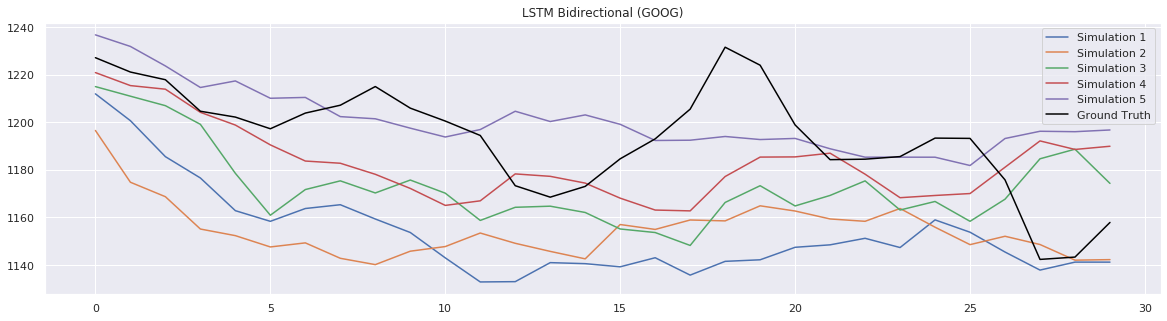

In [202]:
acc2 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results2]
top_5_idx = np.argsort(acc2)[-5:]
results2 = [results2[i] for i in top_5_idx]
acc2 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results2]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results2):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Bidirectional (GOOG)')
plt.show()

In [108]:
class LSTM_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [109]:
results3 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results3.append(deep_future[-test_size:])

W0306 02:23:10.412974 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f06120cada0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:23:10.541996 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f06120cae10>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1


W0306 02:27:38.808590 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f060feddd68>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:27:38.967760 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f0610691d68>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2


W0306 02:32:02.187770 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f060e2e96a0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:32:02.362501 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f060feb8dd8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


W0306 02:36:36.814871 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f060b688dd8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:36:36.978024 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f060da74978>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


W0306 02:41:09.822785 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f060b5106d8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:41:10.003237 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f0609a1a898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


W0306 02:45:35.949124 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f06075f0d68>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:45:36.103334 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f06075f0e48>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 6


W0306 02:50:05.397401 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f0604923c88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:50:05.592847 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f0606dc4cf8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 7


W0306 02:54:32.358382 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f06024fdc18>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:54:32.506698 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f06048e42b0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 8


W0306 02:59:02.039137 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f0602403278>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 02:59:02.222275 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f05fff85dd8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 9


W0306 03:03:33.084657 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f05fe463cc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0306 03:03:33.245780 139710368282432 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f05fffccc88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 10


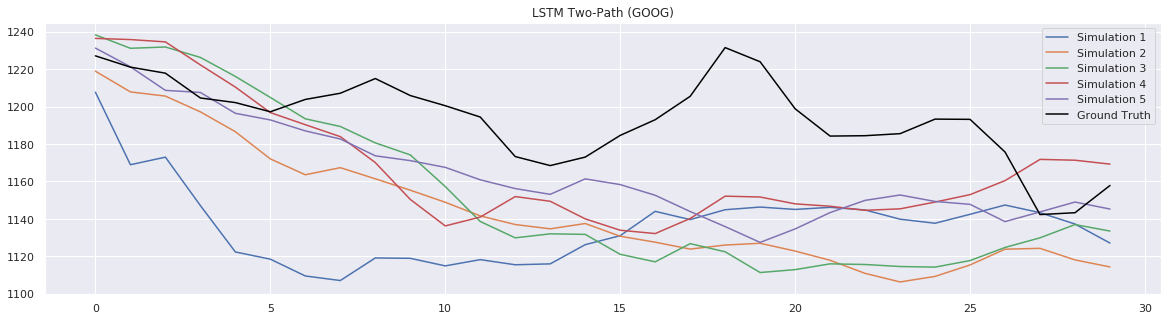

In [205]:
acc3 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results3]
top_5_idx = np.argsort(acc3)[-5:]
results3 = [results3[i] for i in top_5_idx]
acc3 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results3]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results3):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Two-Path (GOOG)')
plt.show()

In [34]:
class GRU:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [52]:
results4 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results4.append(deep_future[-test_size:])

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


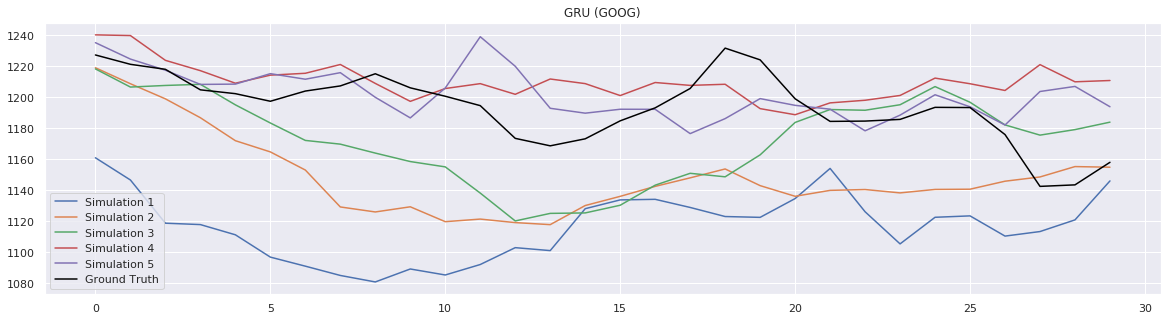

In [207]:
acc4 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results4]
top_5_idx = np.argsort(acc4)[-5:]
results4 = [results4[i] for i in top_5_idx]
acc4 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results4]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results4):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU (GOOG)')
plt.show()

In [60]:
class GRU_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [64]:
results5 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results5.append(deep_future[-test_size:])

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


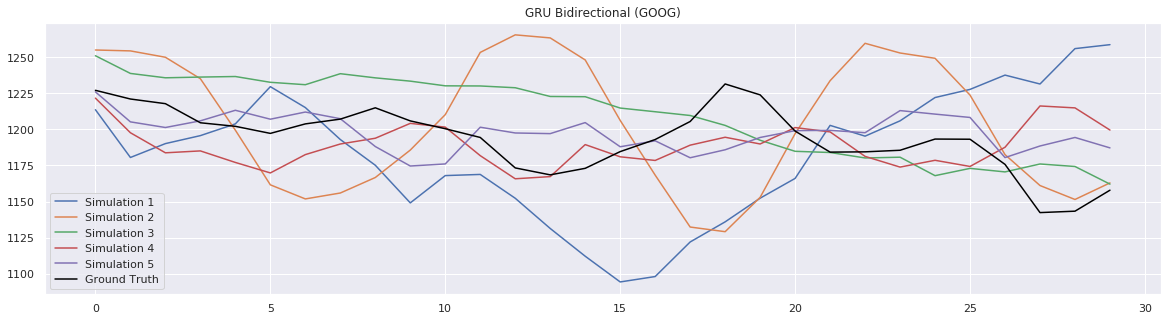

96.85748515710262

In [196]:
acc5 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results5]
top_5_idx = np.argsort(acc5)[-5:]
results5 = [results5[i] for i in top_5_idx]
acc5 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results5]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results5):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Bidirectional (GOOG)')
plt.show()

In [38]:
class GRU_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [47]:
results6 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results6.append(deep_future[-test_size:])

simulation 1
0:02:22.783875
simulation 2
0:02:23.540112
simulation 3
0:02:27.897137
simulation 4
0:02:25.447735
simulation 5
0:02:25.244207
simulation 6
0:02:25.366450
simulation 7
0:02:20.786735
simulation 8
0:02:25.118957
simulation 9
0:02:25.397925
simulation 10
0:02:34.625605


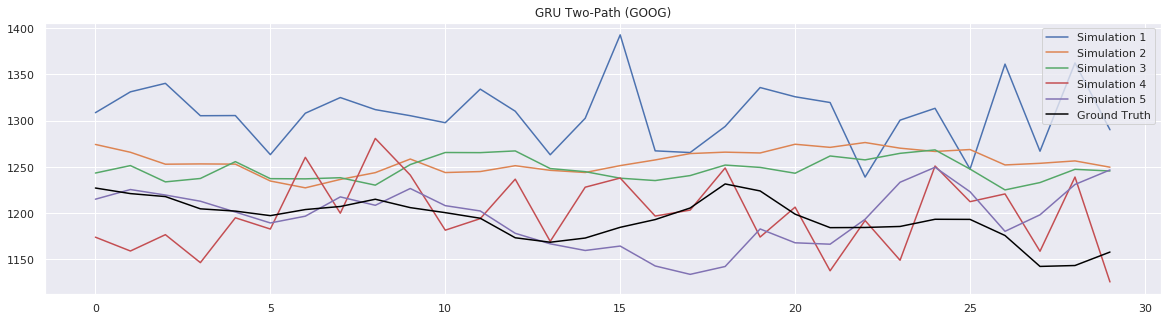

In [195]:
acc6 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results6]
top_5_idx = np.argsort(acc6)[-5:]
results6 = [results6[i] for i in top_5_idx]
acc6 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results6]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results6):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Two-Path (GOOG)')
plt.show()

In [96]:
class VanillaRNN:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [97]:
results7 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results7.append(deep_future[-test_size:])

simulation 1
0:01:10.302124
simulation 2
0:01:11.220314
simulation 3
0:01:09.436748
simulation 4
0:01:10.575595
simulation 5
0:01:10.310599
simulation 6
0:01:10.731178
simulation 7
0:01:13.029341
simulation 8
0:01:13.116462
simulation 9
0:01:12.872223
simulation 10
0:01:11.293103


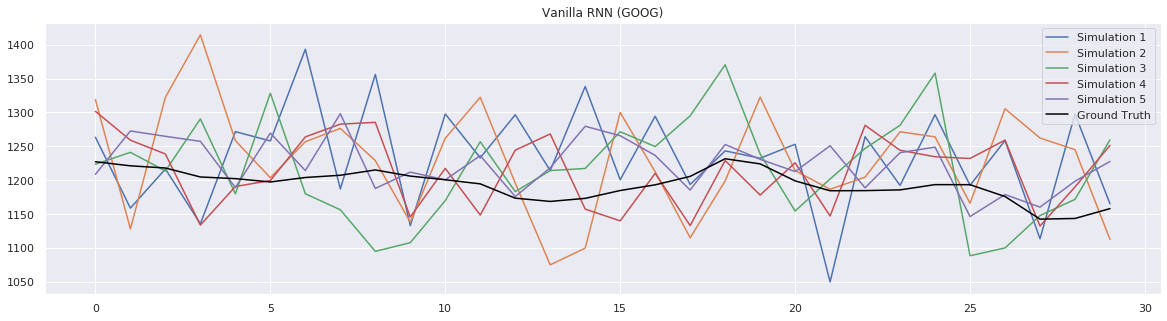

In [194]:
acc7 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results7]
top_5_idx = np.argsort(acc7)[-5:]
results7 = [results7[i] for i in top_5_idx]
acc7 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results7]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results7):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('Vanilla RNN (GOOG)')
plt.show()

In [99]:
class VanillaRNN_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [100]:
results8 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results8.append(deep_future[-test_size:])

simulation 1
0:01:30.795149
simulation 2
0:01:32.931826
simulation 3
0:01:32.065838
simulation 4
0:01:32.114824
simulation 5
0:01:32.388943
simulation 6
0:01:30.494011
simulation 7
0:01:34.071682
simulation 8
0:01:31.291409
simulation 9
0:01:33.298264
simulation 10
0:01:32.523078


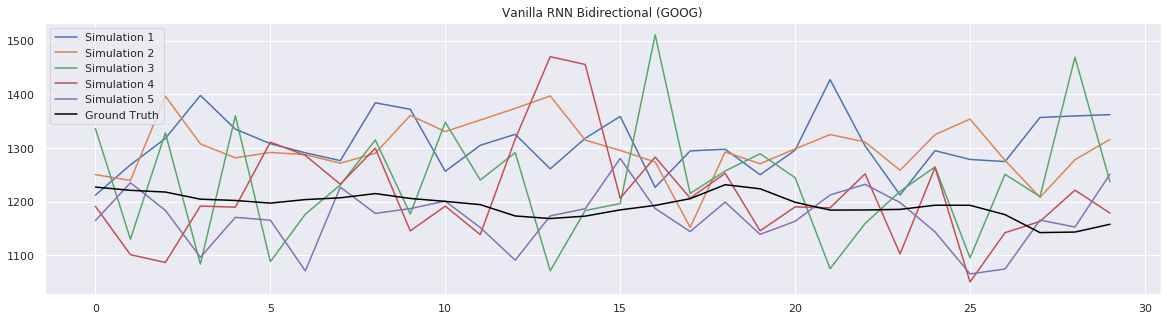

In [193]:
acc8 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results8]
top_5_idx = np.argsort(acc8)[-5:]
results8 = [results8[i] for i in top_5_idx]
acc8 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results8]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results8):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('Vanilla RNN Bidirectional (GOOG)')
plt.show()

In [102]:
class VanillaRNN_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [103]:
results9 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results9.append(deep_future[-test_size:])

simulation 1
0:01:35.750744
simulation 2
0:01:32.192845
simulation 3
0:01:30.387273
simulation 4
0:01:30.413486
simulation 5
0:01:29.668900
simulation 6
0:01:31.686334
simulation 7
0:01:30.823509
simulation 8
0:01:30.729510
simulation 9
0:01:29.945743
simulation 10
0:01:28.965307


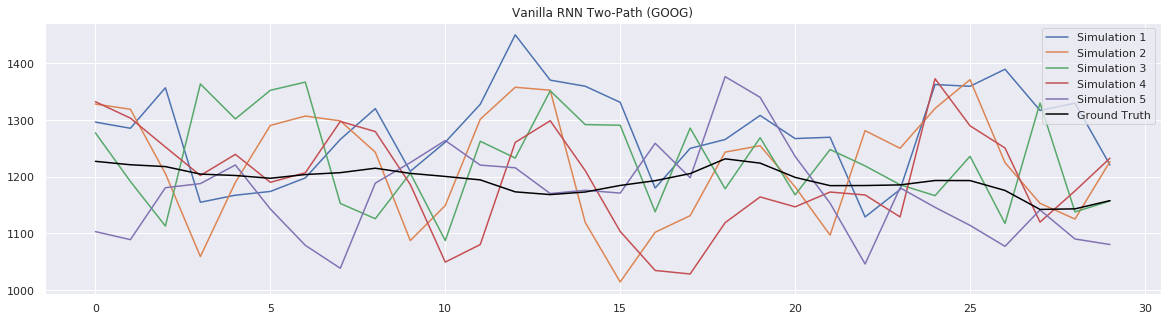

In [192]:
acc9 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results9]
top_5_idx = np.argsort(acc9)[-5:]
results9 = [results9[i] for i in top_5_idx]
acc9 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results9]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results9):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('Vanilla RNN Two-Path (GOOG)')
plt.show()

In [110]:
class LSTM_seq2seq:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [113]:
results10 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results10.append(deep_future[-test_size:])

W0307 22:27:16.447541 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3945b88f98>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:27:16.598256 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3945afa278>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:02:18.952065


W0307 22:29:36.844854 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3944131978>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:29:36.992884 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f394388a828>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:02:12.820270


W0307 22:31:50.983300 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3941f2be48>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:31:51.093049 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3941502780>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:02:14.344279


W0307 22:34:06.610258 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f393f22ffd0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:34:06.764158 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f393f17a6d8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:02:11.095670


W0307 22:36:19.028787 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3933506b38>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:36:19.139359 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3932dd56a0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:02:11.980467


W0307 22:38:32.248639 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f39311cae10>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:38:32.364240 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3930a51668>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 6
0:02:11.477839


W0307 22:40:44.999337 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f392ee43e48>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:40:45.118256 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f392e6ca3c8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 7
0:02:12.964138


W0307 22:42:59.286205 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f392cac3d68>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:42:59.423785 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f392c344550>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 8
0:02:21.945152


W0307 22:45:22.641991 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f392c28b160>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:45:22.779396 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3929fba390>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 9
0:02:18.106711


W0307 22:47:42.082198 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3929fba4e0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0307 22:47:42.192101 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f3927c3a0b8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 10
0:02:16.933749


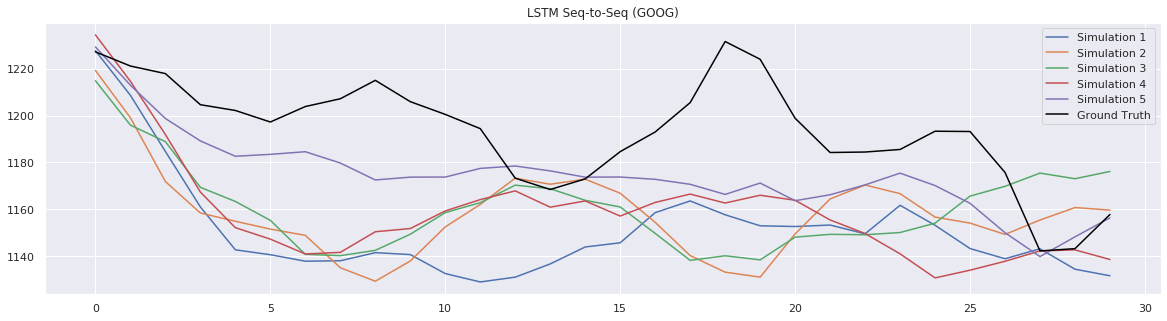

96.6104753086075

In [191]:
acc10 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results10]
top_5_idx = np.argsort(acc10)[-5:]
results10 = [results10[i] for i in top_5_idx]
acc10 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results10]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results10):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Seq-to-Seq (GOOG)')
plt.show()
np.mean(acc10)

In [18]:
class LSTM_seq2seq_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [37]:
results11 = []
simulation_size = 1
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results11.append(deep_future[-test_size:])

W0312 01:39:10.843167 140001675409216 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f548b6be828>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0312 01:39:10.845202 140001675409216 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f548b6bef98>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0312 01:39:11.023172 140001675409216 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f548b81c940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0312 01:39:11.025935 140001675409216 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f53085e9d30>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:07:12.584625


In [39]:
z = list(results11)
z.append(np.array(deep_future[-test_size:]))
results11 = z

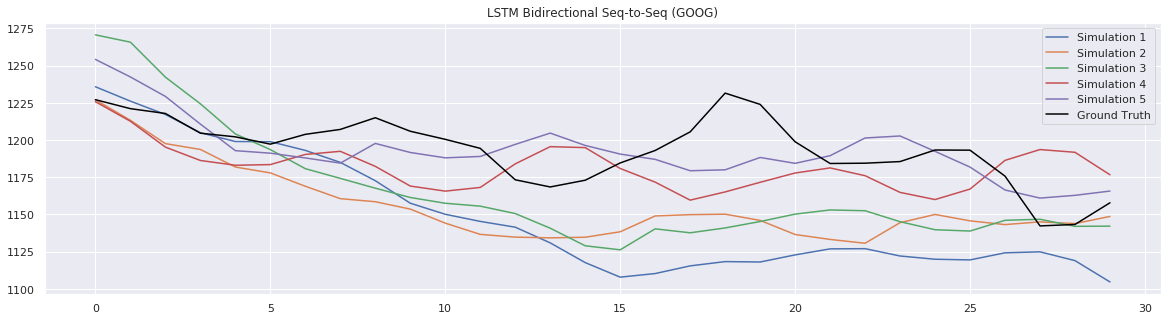

In [190]:
acc11 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results11]
top_5_idx = np.argsort(acc11)[-5:]
results11 = [results11[i] for i in top_5_idx]
acc11 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results11]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results11):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Bidirectional Seq-to-Seq (GOOG)')
plt.show()

In [125]:
# Variational Auto-Encoder
class LSTM_seq2seq_vae:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [130]:
results12 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq_vae(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
           
    fin = datetime.datetime.now()
    print(fin-now)
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results12.append(deep_future[-test_size:])

W0308 01:58:46.871639 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38fc176898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 01:58:47.061378 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38fa84a9b0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1


W0308 03:01:01.202570 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38fc906470>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:01:01.380702 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f9cfedd8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2


W0308 03:03:18.565193 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f8110b70>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:03:18.734732 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f78c2eb8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


W0308 03:05:38.111342 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f80d4c50>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:05:38.291904 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f5549898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


W0308 03:07:58.327528 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f38fe6d8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:07:58.507528 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f3134550>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


W0308 03:10:19.618560 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38f0d7a588>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:10:19.807669 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ef461320>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 6


W0308 03:12:41.502593 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ef07f080>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:12:41.681397 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ee9a5a20>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 7


W0308 03:14:58.360206 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ecce49e8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:14:58.536395 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ec4840b8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 8


W0308 03:17:16.089712 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ecccf9b0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:17:16.243197 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38ea105e80>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 9


W0308 03:19:34.347984 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38e84f05f8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0308 03:19:34.502388 139915415172928 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f38e62ff198>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 10


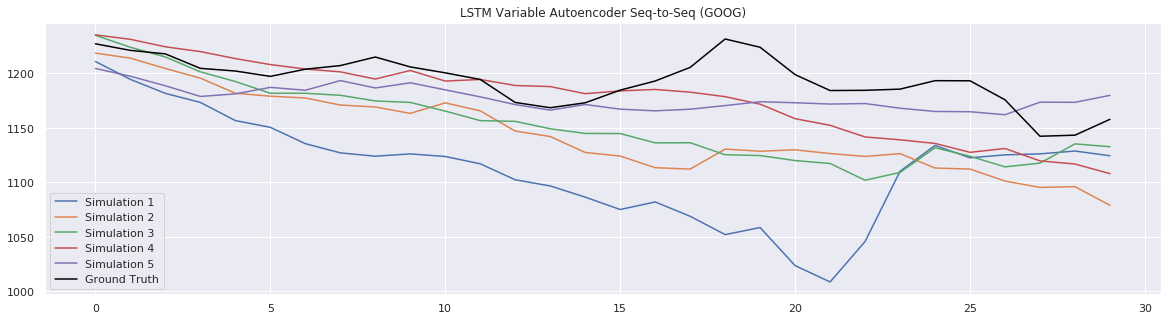

In [189]:
acc12 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results12]
top_5_idx = np.argsort(acc12)[-5:]
results12 = [results12[i] for i in top_5_idx]
acc12 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results12]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results12):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Variable Autoencoder Seq-to-Seq (GOOG)')
plt.show()

In [132]:
class GRU_seq2seq:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [133]:
results13 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results13.append(deep_future[-test_size:])

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


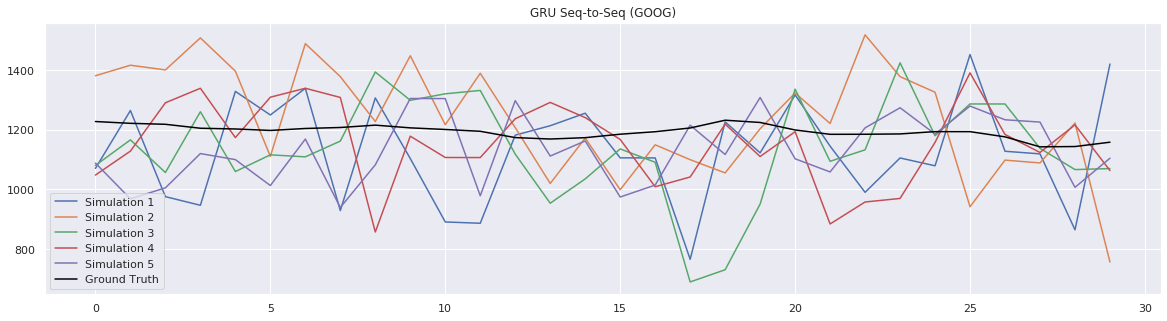

In [188]:
acc13 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results13]
top_5_idx = np.argsort(acc13)[-5:]
results13 = [results13[i] for i in top_5_idx]
acc13 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results13]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results13):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Seq-to-Seq (GOOG)')
plt.show()

In [31]:
class GRU_seq2seq_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [46]:
results14 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results14.append(deep_future[-test_size:])

simulation 1
0:05:52.857056
simulation 2
0:05:48.764361
simulation 3
0:05:54.481141
simulation 4
0:05:49.554507
simulation 5
0:05:52.426415
simulation 6
0:05:54.606443
simulation 7
0:05:51.537067
simulation 8
0:05:50.911107
simulation 9
0:05:50.231721
simulation 10
0:05:45.824940


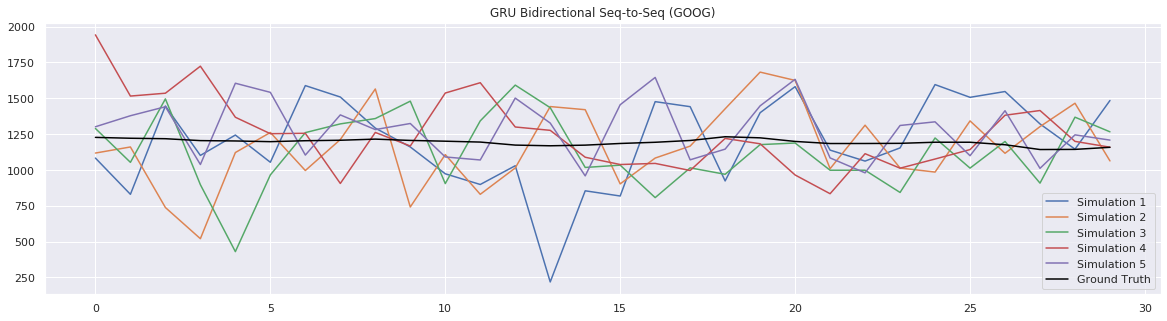

In [187]:
acc14 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results14]
top_5_idx = np.argsort(acc14)[-5:]
results14 = [results14[i] for i in top_5_idx]
acc14 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results14]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results14):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Bidirectional Seq-to-Seq (GOOG)')
plt.show()

In [34]:
class GRU_seq2seq_vae:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [35]:
results15 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq_vae(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size
    
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results15.append(deep_future[-test_size:])

simulation 1
0:03:45.903279
simulation 2
0:03:48.652556
simulation 3
0:03:48.278639
simulation 4
0:03:51.562683
simulation 5
0:03:46.995985
simulation 6
0:03:43.768999
simulation 7
0:03:47.762563
simulation 8
0:03:46.963879
simulation 9
0:03:57.590592
simulation 10
0:03:53.550062


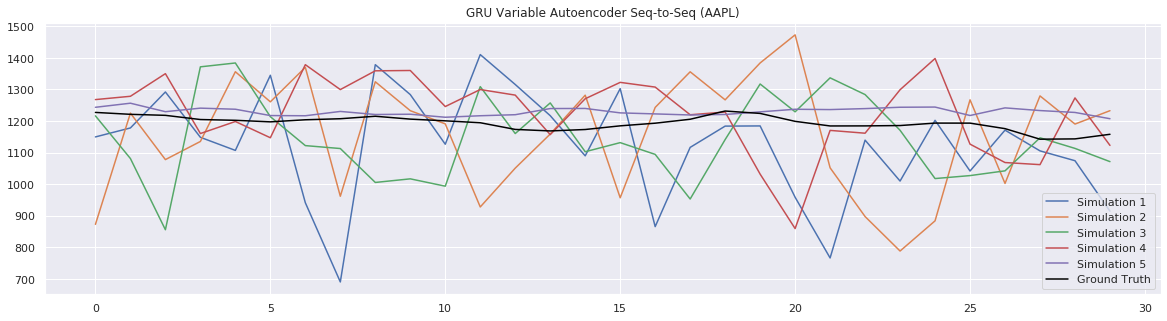

In [186]:
acc15 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results15]
top_5_idx = np.argsort(acc15)[-5:]
results15 = [results15[i] for i in top_5_idx]
acc15 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results15]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results15):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Variable Autoencoder Seq-to-Seq (GOOG)')
plt.show()

In [185]:
print('%.4f'%(np.mean(acc1)))
print('%.4f'%(np.mean(acc2)))
print('%.4f'%(np.mean(acc3)))
print('%.4f'%(np.mean(acc4)))
print('%.4f'%(np.mean(acc5)))
print('%.4f'%(np.mean(acc6)))
print('%.4f'%(np.mean(acc7)))
print('%.4f'%(np.mean(acc8)))
print('%.4f'%(np.mean(acc9)))
print('%.4f'%(np.mean(acc10)))
print('%.4f'%(np.mean(acc11)))
print('%.4f'%(np.mean(acc12)))
print('%.4f'%(np.mean(acc13)))
print('%.4f'%(np.mean(acc14)))
print('%.4f'%(np.mean(acc15)))

95.2384
97.1949
95.7843
96.2107
96.8575
94.4759
94.1518
91.0423
91.9962
96.6105
96.8071
95.7206
86.4332
78.3311
88.9012


In [178]:
a1 = np.array(results)
a2 = np.array(results2)
a3 = np.array(results3)
a4 = np.array(results4)
a5 = np.array(results5)
a6 = np.array(results6)
a7 = np.array(results7)
a8 = np.array(results8)
a9 = np.array(results9)
a10 = np.array(results10)
a11 = np.array(results11)
a12 = np.array(results12)
a13 = np.array(results13)
a14 = np.array(results14)
a15 = np.array(results15)

In [179]:
np.save('goog_lstm.npy', a1)
np.save('goog_lstm_bid.npy', a2)
np.save('goog_lstm_2p.npy', a3)
np.save('goog_gru.npy', a4)
np.save('goog_gru_bid.npy', a5)
np.save('goog_gru_2p.npy', a6)
np.save('goog_vrnn.npy', a7)
np.save('goog_vrnn_bid.npy', a8)
np.save('goog_vrnn_2p.npy', a9)
np.save('goog_seq2seq.npy', a10)
np.save('goog_seq2seq_vae.npy', a12)
np.save('goog_seq2seq_bid.npy', a11)
np.save('goog_grubid_seq2seq.npy', a14)
np.save('goog_gru_seq2seq.npy', a13)
np.save('goog_gruvae_seq2seq.npy', a15)